In [1]:
import numpy as np
from numpy.linalg import norm,inv,pinv,slogdet,matrix_rank
from numpy import array,trace,diag,zeros,ones,full,sqrt,eye
from scipy.stats import multivariate_normal
import pickle
import copy

from time import time
from tqdm import tnrange,tqdm_notebook

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Circle,Ellipse
import imageio


import torch
from robusttracking.sensors import *
from robusttracking.estimator import *
from robusttracking.controller import move,robustmove

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.monospace": 'Computer Modern Typewriter'
})


import sys
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [2]:
torch.set_default_dtype(torch.float64)

# Plots

In [3]:
color_active_ranging = 'orange'
color_inactive_ranging = 'tomato'
color_active_doppler = 'green'
color_inactive_doppler = 'tomato'
color_target = 'blue'
color_est = 'red'

def plot_trajectories(ax,targets,sensors,ests,xlim,ylim,n_ranging_sensors,T_start=0):
    ax.scatter(targets[:,0,:], targets[:,1,:],c=color_target,alpha=0.02)
    ax.scatter(targets[-1,0,:], targets[-1,1,:],c=color_target,alpha=1,label='Target')
    
    if n_ranging_sensors>0:
        if T_start>0:
            ax.scatter(sensors[:T_start,0,:n_ranging_sensors], sensors[:T_start,1,:n_ranging_sensors],facecolors='none', edgecolors=color_inactive_ranging)
        ax.scatter(sensors[T_start:,0,:n_ranging_sensors], sensors[T_start:,1,:n_ranging_sensors], alpha=0.02,c=color_active_ranging)
        ax.scatter(sensors[-1,0,:n_ranging_sensors], sensors[-1,1,:n_ranging_sensors], alpha=1,c=color_active_ranging,label='Ranging sensor')
    
    if n_ranging_sensors==0 or n_ranging_sensors<sensors.shape[-1]:
        if T_start>0:
            ax.scatter(sensors[:T_start,0,n_ranging_sensors:], sensors[:T_start,1,n_ranging_sensors:],facecolors='none', edgecolors=color_inactive_doppler)

        ax.scatter(sensors[T_start:,0,n_ranging_sensors:], sensors[T_start:,1,n_ranging_sensors:], alpha=0.02,c=color_active_doppler)
        ax.scatter(sensors[-1,0,n_ranging_sensors:], sensors[-1,1,n_ranging_sensors:], alpha=1,c=color_active_doppler,label='Doppler sensor')
    
    ax.scatter(ests[:,0,:], ests[:,1,:], alpha=1,c='red',s=0.1,label='Estimate')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel('$p_x$ [m]')
    ax.set_ylabel('$p_y$ [m]')

def plot_trajectories_xz(ax,title,targets,sensors,ests,xlim,ylim,n_ranging_sensors,T_start=0):
    ax.scatter(targets[:,0,:], targets[:,2,:],c=color_target,alpha=0.02)
    ax.scatter(targets[-1,0,:], targets[-1,2,:],c=color_target,alpha=1,label='Target')
    
    if n_ranging_sensors>0:
        if T_start>0:
            ax.scatter(sensors[:T_start,0,:n_ranging_sensors], sensors[:T_start,2,:n_ranging_sensors],facecolors='none', edgecolors=color_inactive_ranging)
        ax.scatter(sensors[T_start:,0,:n_ranging_sensors], sensors[T_start:,2,:n_ranging_sensors], alpha=0.02,c=color_active_ranging)
        ax.scatter(sensors[-1,0,:n_ranging_sensors], sensors[-1,2,:n_ranging_sensors], alpha=1,c=color_active_ranging,label='Ranging sensor')
    
    if n_ranging_sensors==0 or n_ranging_sensors<sensors.shape[-1]:
        if T_start>0:
            ax.scatter(sensors[:T_start,0,n_ranging_sensors:], sensors[:T_start,2,n_ranging_sensors:],facecolors='none', edgecolors=color_inactive_doppler)
            
        ax.scatter(sensors[T_start:,0,n_ranging_sensors:], sensors[T_start:,2,n_ranging_sensors:], alpha=0.02,c=color_active_doppler)
        ax.scatter(sensors[-1,0,n_ranging_sensors:], sensors[-1,2,n_ranging_sensors:], alpha=1,c=color_active_doppler,label='Doppler sensor')
    
    ax.scatter(ests[:,0,:], ests[:,2,:], alpha=1,c='red',s=0.1,label='Estimate')
    #ax.set_title(title)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel('$p_x$ [m]')
    ax.set_ylabel('$p_z$ [m]')
    
def plotframe(T,frame,rect,n_range_sensors,T_start=0):
    fig = plt.figure(figsize=(5,4))
    
    ax = plt.gca()

    dim,n_target = frame['est'].shape
    for nt in range(n_target):
        ax.add_patch(Circle((frame['target'][0,nt],frame['target'][1,nt]), 1, color=color_target,label='Target'))
    
    sensors = frame['sensor']
    obs = frame['obs']
    
    ranging_label=False
    for i in range(n_range_sensors):
        c = (sensors[0,i], sensors[1,i])
        r = obs[0,i]
        if frame["t"]>=T_start:
            if ranging_label==False:
                ax.add_patch(Circle(c, 1, color=color_active_ranging,label='Ranging sensor'))
                ranging_label=True
            else:
                ax.add_patch(Circle(c, 1, color=color_active_ranging))  
        else:
            ax.add_patch(Circle(c, 1, color=color_inactive_ranging))
    
    doppler_label = False
    for i in range(sensors.shape[1]-n_range_sensors):
        c = (sensors[0,i+n_range_sensors], sensors[1,i+n_range_sensors])
        if frame["t"]>=T_start:
            if doppler_label==False:
                ax.add_patch(Circle(c, 1, color=color_active_doppler,label='Doppler sensor'))
                doppler_label=True
            else:
                ax.add_patch(Circle(c, 1, color=color_active_doppler))
        else:
            ax.add_patch(Circle(c, 1, color=color_inactive_doppler))
    
    plt.title(f'T={frame["t"]}/{T} [s]')
    plt.ylim(rect[2],rect[3])
    plt.xlim(rect[0],rect[1])
    plt.legend(loc='upper left')
    
    plt.savefig(f'./img/img_{frame["t"]}.pdf', 
                    transparent = False,  
                    facecolor = 'white'
                   )
    
    plt.savefig(f'./img/img_{frame["t"]}.png', 
                    transparent = False,  
                    facecolor = 'white'
                   )
    fig.clf()
    plt.close(fig)
    
def plotgif(T,frames,rect,prefix,n_range_sensors):
    gif_imgs = []
    for frame in frames:
        plotframe(T,frame,rect,n_range_sensors)
        gif_imgs.append(imageio.v2.imread(f'./img/img_{frame["t"]}.png'))
    
    imageio.mimsave(f'./{prefix}_T={T}.gif',gif_imgs,fps = 10)  
    


In [4]:
def extract_costs(frames):
    position_err = []
    sensor_trac = []
    target_trac = []
    est_trac = []
    velocity_err = []
    crb_rmse_p = []
    crb_rmse_v = []
    est_status = []
    v = []
    dim = frames[0]['target'].shape[0]//2
    for frame in frames:
        pe = np.linalg.norm(frame['target'][:dim]-frame['est'][:dim],axis=0)
        position_err.append(pe)
        sensor_trac.append(frame['sensor'])
        target_trac.append(frame['target'])
        est_trac.append(frame['est'])
        crb_rmse_p.append(frame['crb_rmse_p'])
        crb_rmse_v.append(frame['crb_rmse_v'])
        est_status.append(frame['est_status'])
        
        ve = np.linalg.norm(frame['target'][dim:]-frame['est'][dim:],axis=0)
        velocity_err.append(ve)
        
        if 'v' in frame:
            v.append(frame['v'])
            
    ret = {'sensors':array(sensor_trac)
           ,'targets':array(target_trac)
           ,'ests':array(est_trac)
           ,'est_status':array(est_status)
          ,'rmse_p':array(position_err)
          ,'crb_rmse_p':array(crb_rmse_p)
          ,'rmse_v':array(velocity_err)
          ,'crb_rmse_v':array(crb_rmse_v),'v':array(v)}
    
    return ret

    
def tracking_fuse(T,K,sensor_torch,target_torch,sensor_np,target_np,lr_s,lr_t,rs,rt,rv,w,trajectory,est_0,dim,n_dynamic_sensors,Q,multistarts=False,T_start=0,robust=True,gamma=1,n_iter=2000):
    """
    Params
        T: Total number of time step in tracking
        K: The time horizon for planning
        sensor_torch,sensor_np: Sensor simulator, the suffix distinguishes which framework it uses
        target_torch,target_np: Target simulator, the suffix distinguishes which framework it uses
        lr_s: Learning rate of maximization
        lr_t: Learning rate of minimzation
        rs: Bound of sensors' action
        rt: Bound of targets' action
        rv: Bound of initial estimation(95% quantile of chi square)
        w: weights of cost length(w)=K, the weight of cost of each step
        trajectory: a function, produce initial placement of sensors,targets and a trajectory of targets
        est_0: initial guess of target for MLE optimizer
        dim: 2 or 3, 2D or 3D
        n_dynamic_sensors: number of dynamic sensors in total
        T_start: when does the algorithm turn on, default zero
        robust: whether use minimax or minimize only
        gamma: the weight of velocity crb in costs
    return
        a list of frames 
    """
    frames = []
    
    x_t_n,x_s_n,u_t = trajectory(T)
    
    n_target = x_t_n.shape[-1]
    
    x_pred = est_0.copy()
    cov_pred = np.zeros((n_target,2*dim,2*dim))
    cov_prev = np.zeros((n_target,2*dim,2*dim))
    for it in range(n_target):
        cov_pred[it] = eye(2*dim)*1e12#target_np.predictC(eye(2*dim)*1e12,Q)
        cov_prev[it] = eye(2*dim)*1e12
    
    for t in tnrange(T):
        frame = {}
        
        frame['target'] = x_t_n
        frame['sensor'] = x_s_n
        
        #STEP 1. read observaion
        obs = observe(sensor_np.hx(x_t_n,x_s_n),sensor_np.sx(x_t_n,x_s_n))
        frame['obs'] = obs
        
        #STEP 2. estimate target
        est,C_sqt,status,C_ =  mle_fuse(sensor_np,x_pred,cov_pred,x_s_n,obs,multistarts)
        frame['est'] = est
        frame['C_sqt'] = C_sqt
        frame['est_status'] = status
        for it in range(n_target):
            cov_pred[it] = target_np.predictC(C_[it],Q)
        
        #STEP 3. evaluate using true 
        fim = fisher_information(sensor_np.hx(x_t_n,x_s_n),sensor_np.sx(x_t_n,x_s_n),sensor_np.H(x_t_n,x_s_n),sensor_np.S(x_t_n,x_s_n))
        cov_prev_ = np.zeros((n_target,2*dim,2*dim))
        crb_rmse_p = []
        crb_rmse_v = []
        
        for it in range(n_target):
            fi = inv(target_np.predictC(cov_prev[it],Q)) #eq. 15
            fi[:fim[it].shape[0],:fim[it].shape[1]] += fim[it]
            C_ = inv(fi)
            crb_rmse_p.append(sqrt(diag(C_[:dim,:dim])).sum())
            crb_rmse_v.append(sqrt(diag(C_[dim:,dim:])).sum())
            cov_prev_[it] = C_.copy()
        cov_prev = cov_prev_.copy()
        #print(np.linalg.norm((est-x_t_n)[:3,:],axis=0),crb_rmse_p)
        
    
        
        frame['crb_rmse_p'] = crb_rmse_p
        frame['crb_rmse_v'] = crb_rmse_v
        
        #STEP 4. plan nextmove
        if t>=T_start:
            x_s = torch.tensor(x_s_n)

            if robust:
                u_s,_ = robustmove(K,sensor_torch,target_torch,x_s,torch.tensor(est),lr_s,lr_t,rs,rt,rv,torch.tensor(C_sqt),w,n_dynamic_sensors,gamma=gamma,n_iter=n_iter,regularize=True,Q=torch.tensor(Q))
            else:
                u_s,_ = move(K,sensor_torch,target_torch,x_s,torch.tensor(est),lr_s,rs,rt,torch.tensor(C_sqt),w,n_dynamic_sensors,is_target=False,gamma=gamma,n_iter=n_iter,regularize=True,Q=torch.tensor(Q))
            
            u_s_n = u_s[0].numpy()
            
        else:#Haven't started yet
            u_s_n = np.zeros((x_s_n.shape[0],n_dynamic_sensors))
        
        
        #STEP 5. update prediction
        x_pred = target_np.transition(est,zeros(est.shape))
        
        #STEP 6. sensor act
        x_s_n = sensor_np.transition(x_s_n,u_s_n)
        
        #STEP 7. target act
        u_t_n = u_t[:,:,t]
        x_t_n = target_np.transition(x_t_n,u_t_n)
        
        frame['t'] = t
        frames.append(frame)
        
    return frames


In [5]:
def case_2D_1(T):
    points =  np.array([[-5,0],[-2.5,5],[0,20],[2,23],[15,0],[12,-5],[5,0],[0,5],[-15,10]])
    _,_,a = trajectory_generator_2D(points,T+1,0)
    
    x_t = zeros((4,1))
    x_t[0,:] = -5
    x_t[1,:] = 0
    
    x_s = zeros((4,3))
    
    x_s[0,0] = -5.01
    x_s[0,1] = -5
    x_s[0,2] = -4.99
    x_s[1,0] = -5
    x_s[1,1] = -10
    x_s[1,2] = -15
    
    u_t = zeros((4,1,T))
    u_t[2,:,:] = a[:,0]
    u_t[3,:,:] = a[:,1]
    return x_t,x_s,u_t

def case_2D_2(T):
    x_t = zeros((4,1))
    x_t[0,:] = -5
    x_t[1,:] = 0
    
    x_s = zeros((4,3))
    
    x_s[0,0] = -5.01
    x_s[0,1] = -5
    x_s[0,2] = -4.99
    x_s[1,0] = -5
    x_s[1,1] = -10
    x_s[1,2] = -15
    
    u_t = zeros((4,1,T))
    u_t[3,:,:T//2] =10/T
    u_t[3,:,T//2:] = -5/T
    return x_t,x_s,u_t

def case_2D_3(T):
    x_t = zeros((4,1))
    x_t[0,:] = -5
    x_t[1,:] = 0
    x_t[2,:] = 0.
    x_t[3,:] = 1.8
    
    x_s = zeros((4,3))
    
    x_s[0,0] = -5.01
    x_s[0,1] = -5
    x_s[0,2] = -4.99
    x_s[1,0] = -5
    x_s[1,1] = -10
    x_s[1,2] = -15
    
    u_t = zeros((4,1,T))
    u_t[2,:,:T//2] = -2/T
    u_t[2,:,T//2:] = 2/T
    
    u_t[3,:,T//4:T*3//4] = -7.2/T
    return x_t,x_s,u_t

In [11]:
#setting constant
target2D_torch = Target2DT()
target2D_np = Target2D()

target3D_torch = Target3DT()
target3D_np = Target3D()

K = 3
T = 100 
lr_t = 0.01
lr_s = 0.03
w = torch.tensor([1. for k in range(K)])

In [15]:
dim = 2
bmax = 0.02
amax = 1.52
range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
range_u_t = [-amax,amax]
q = np.sqrt(q_alpha_d(2*dim))
range_v = [-q,q]
Q = target2D_np.getUniformQ(amax)
x_init_guess = np.array([[-100.,0.3, 0, 0]]).T #a poor guess for mle initialization



trajectory = case_2D_1
n_dynamic_sensors = 3
sensor_torch = RangingSensor2DT()
sensor_np = RangingSensor2D()

In [16]:
frames_1 = tracking_fuse(T,K,sensor_torch,target2D_torch,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,robust=True,n_iter=1000)
result_1 = extract_costs(frames_1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
#Save data for plots
with open('plotsdata/2d_trajectory_1.pk','wb') as f:
    pickle.dump(result_1,f)

In [28]:
#Load plots data
with open('plotsdata/2d_trajectory_1.pk','rb') as f:
    result_1 = pickle.load(f)

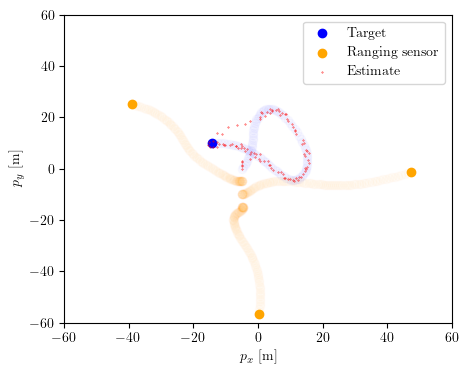

In [31]:
plt.figure(figsize=(5,4))
ax=plt.gca()
xlim = [-60,60]
ylim = [-60,60]
plot_trajectories(ax,result_1['targets'], result_1['sensors'][0:,:,:],result_1['ests'],xlim,ylim,3)
plt.legend()

In [32]:
dim = 2
bmax = 0.1
amax = 0.2
range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
range_u_t = [-amax,amax]
q = np.sqrt(q_alpha_d(2*dim))
range_v = [-q,q]
Q = target2D_np.getUniformQ(amax)
x_init_guess = np.array([[-100.,0.3, 0, 0]]).T #a poor guess for mle initialization


trajectory = case_2D_2
n_dynamic_sensors = 3
sensor_torch = RangingSensor2DT()
sensor_np = RangingSensor2D()

In [34]:
frames_2 = tracking_fuse(T,K,sensor_torch,target2D_torch,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x_init_guess,dim,n_dynamic_sensors,Q,robust=True,n_iter=1000)
result_2 = extract_costs(frames_2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [35]:
#Save data for plots
with open('plotsdata/2d_trajectory_2.pk','wb') as f:
    pickle.dump(result_2,f)

In [36]:
#Load plots data
with open('plotsdata/2d_trajectory_2.pk','rb') as f:
    result_2 = pickle.load(f)

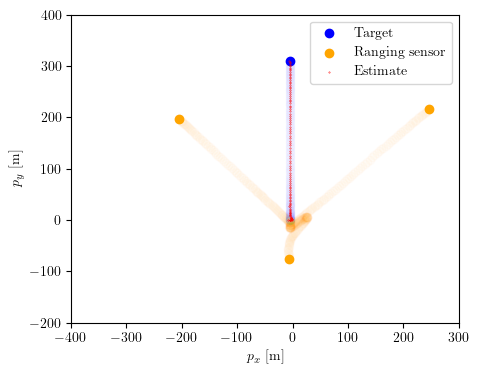

In [37]:
plt.figure(figsize=(5,4))
ax=plt.gca()
xlim = [-400,300]
ylim = [-200,400]
plot_trajectories(ax,result_2['targets'], result_2['sensors'],result_2['ests'],xlim,ylim,3)
plt.legend()
plt.savefig('one_target_2D_straight.pdf')

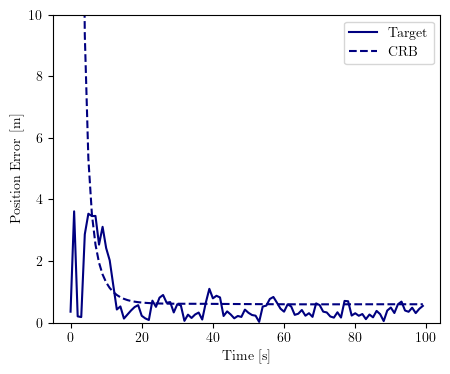

In [38]:
plt.figure(figsize=(5,4))
ax=plt.gca()
plt.plot(result_2['rmse_p'],c='Navy',label='Target')
plt.plot(result_2['crb_rmse_p'],c='Navy',linestyle='dashed',label='CRB')
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m]')
plt.ylim(0,10)
plt.legend()
plt.savefig('one_target_2D_straight_perr.pdf')

In [39]:
dim = 2
bmax = 0.1
amax = 0.2
range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
range_u_t = [-amax,amax]
q = np.sqrt(q_alpha_d(2*dim))
range_v = [-q,q]
Q = target2D_np.getUniformQ(amax)
x_init_guess = np.array([[-100.,0.3, 0, 0]]).T #a poor guess for mle initialization


trajectory = case_2D_3
n_dynamic_sensors = 3
sensor_torch = RangingSensor2DT()
sensor_np = RangingSensor2D()

In [41]:
frames_3 = tracking_fuse(T,K,sensor_torch,target2D_torch,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,previous_est,dim,n_dynamic_sensors,Q,robust=True,n_iter=1000)
result_3 = extract_costs(frames_3)

  0%|          | 0/100 [00:00<?, ?it/s]

In [42]:
#Save data for plots
with open('plotsdata/2d_trajectory_3.pk','wb') as f:
    pickle.dump(result_3,f)

In [43]:
#Load plots data
with open('plotsdata/2d_trajectory_3.pk','rb') as f:
    result_3 = pickle.load(f)

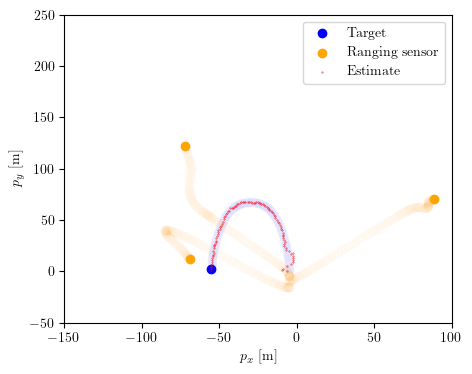

In [44]:
plt.figure(figsize=(5,4))
ax=plt.gca()
xlim = [-150,100]
ylim = [-50,250]
plot_trajectories(ax,result_3['targets'], result_3['sensors'],result_3['ests'],xlim,ylim,3)
plt.legend()
plt.savefig('one_target_2D_Ushape.pdf')

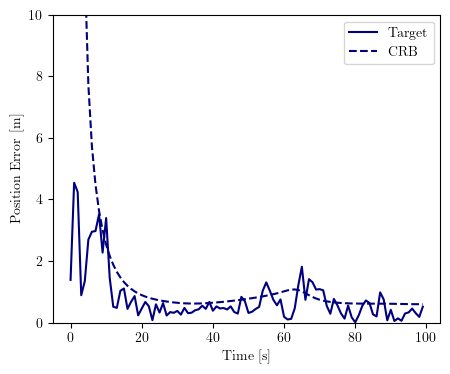

In [45]:
plt.figure(figsize=(5,4))
ax=plt.gca()
plt.plot(result_3['rmse_p'],c='Navy',label='Target')
plt.plot(result_3['crb_rmse_p'],c='Navy',linestyle='dashed',label='CRB')
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m]')
plt.ylim(0,10)
plt.legend()
plt.savefig('one_target_2D_Ushape_perr.pdf')

In [48]:
def monte_carlo_tracking(M,T,K,range_u_s,range_u_t,range_v,w,robust,costs,Q,n_dynamic_sensors,dim,trajectory,previous_est):
    fname = f'plotsdata/mc_k{K}_robust.pk' if robust else f'plotsdata/mc_k{K}.pk'
    
    try:
        with open(fname,'rb') as f:
            costs = pickle.load(f)
    except:
        print('?')
    for _ in tnrange(M):
        frames_ = tracking_fuse(T,K,sensor_torch,target2D_torch,sensor_np,target2D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,previous_est,dim,n_dynamic_sensors,Q,robust=robust,n_iter=1000)
        result_ = extract_costs(frames_)
        costs.append(result_['rmse_p'])
        
    with open(fname,'wb') as f:
        pickle.dump(costs,f)
    return costs

In [47]:
dim = 2
bmax = 0.1
amax = 0.2
range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
range_u_t = [-amax,amax]
q = np.sqrt(q_alpha_d(2*dim))
range_v = [-q,q]
Q = target2D_np.getUniformQ(amax)
x_init_guess = np.array([[-100.,0.3, 0, 0]]).T #a poor guess for mle initialization


trajectory = case_2D_3
n_dynamic_sensors = 3
sensor_torch = RangingSensor2DT()
sensor_np = RangingSensor2D()

repeat=100

In [ ]:
costs = []
robust = True
K=3
monte_carlo_tracking(repeat,T,K,range_u_s,range_u_t,range_v,w,robust,costs,Q,n_dynamic_sensors,dim,trajectory,previous_est)

In [ ]:
costs = []
robust = False
K = 3
monte_carlo_tracking(repeat,T,K,range_u_s,range_u_t,range_v,w,robust,costs,Q,n_dynamic_sensors,dim,trajectory,previous_est)

In [ ]:
costs = []
robust = True
K = 5
monte_carlo_tracking(repeat,T,K,range_u_s,range_u_t,range_v,w,robust,costs,Q,n_dynamic_sensors,dim,trajectory,previous_est)

In [ ]:
costs = []
robust = True
K=1
monte_carlo_tracking(repeat,T,K,range_u_s,range_u_t,range_v,w,robust,costs,Q,n_dynamic_sensors,dim,trajectory,previous_est)

In [50]:
with open('plotsdata/mc_k1_robust.pk','rb') as f:
    costk1 = pickle.load(f)[:100]
    
with open('plotsdata/mc_k3_robust.pk','rb') as f:
    costk3 = pickle.load(f)[:100]
    
with open('plotsdata/mc_k3.pk','rb') as f:
    costk3_n = pickle.load(f)[:100]
    
with open('plotsdata/mc_k5_robust.pk','rb') as f:
    costk5 = pickle.load(f)[:100]

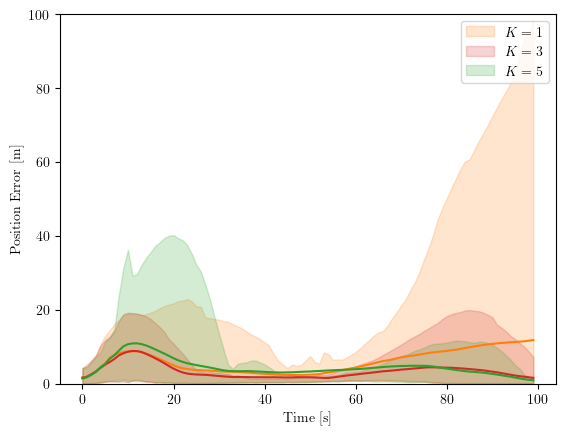

In [51]:
plt.plot(array(costk1).mean(axis=0),c='C1')
plt.fill_between(range(100),np.quantile(array(costk1),0.05,axis=0).flatten(),np.quantile(array(costk1),0.95,axis=0).flatten(),alpha=0.2,color='C1',label='$K=1$')
plt.plot(array(costk3).mean(axis=0),c='C3')
plt.fill_between(range(100),np.quantile(array(costk3),0.05,axis=0).flatten(),np.quantile(array(costk3),0.95,axis=0).flatten(),alpha=0.2,color='C3',label='$K=3$')
plt.plot(array(costk5).mean(axis=0),c='C2')
plt.fill_between(range(100),np.quantile(array(costk5),0.05,axis=0).flatten(),np.quantile(array(costk5),0.95,axis=0).flatten(),alpha=0.2,color='C2',label='$K=5$')
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m]')
plt.ylim(0,100)
plt.legend()
plt.savefig('Varing_k_fuse.pdf')

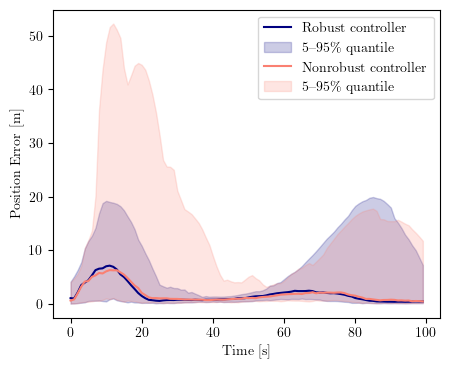

In [53]:
def plot_monticarlo(ax,cost,label,color):
    acost = array(cost)
    ax.plot(np.quantile(acost,0.5,axis=0),c=color,label=label)
    ax.fill_between(range(acost.shape[1]),np.quantile(acost,0.05,axis=0).flatten(),np.quantile(acost,0.95,axis=0).flatten(),alpha=0.2,color=color,label='5--95\% quantile')

plt.figure(figsize=(5,4))
ax= plt.gca()
plot_monticarlo(ax,costk3,'Robust controller','navy')
plot_monticarlo(ax,costk3_n,'Nonrobust controller','salmon')
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m]')
plt.legend()
plt.savefig('one-target-montecarlo-fuse.pdf')

In [59]:
def case_3D_12(T):
    x_s = zeros((6,5))
    x_s[:,0] = array([-750.,501.,-5.2,5,0.,0.])
    x_s[:,1] = array([-752.,350.,-5,5,0.,0.])
    x_s[:,2] = array([-750,200.01,-15.,5.,0.,0.])
    x_s[:,3] = array([-750.03,-50.,-15.05,5.,0.,0.])
    x_s[:,4] = array([-749.03,-200.,5.05,5.,0.,0.])

    
    #single target
    x_t = zeros((6,1))
    x_t[:,0] = array([850,-100.,5,-1.,0.,0.])
  
    #accelerations 
    points = np.array([[850,-100],[400,-110],[0,0],[-150.,250],[-100,700]])
    _,_,a = trajectory_generator_2D(points,T+1,0)
    u_t =  zeros((6,1,T))
    
    
    u_t[3,:,:] = a[:,0]
    u_t[4,:,:] = a[:,1]
    return x_t,x_s,u_t


In [82]:
K=3
dim = 3
bmax = 0.7
amax = 50.
range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
range_u_t = [-amax,amax]
q = q_alpha_d(2*dim)
range_v = [-q,q]
Q = target3D_np.getUniformQ(amax)


x0_ = trajectory(T)[0]
sigma_init2 = 250**2
x0_guess = np.zeros(x0_.shape)
x0_guess[:2,:] = multivariate_normal.rvs(mean=x0_[:2,:].flatten(), cov=np.eye(2*x0_.shape[1])*sigma_init2).reshape((2,x0_.shape[1]))#a poor guess for mle initialization with variance 250^2


trajectory = case_3D_12
n_dynamic_sensors = 5
sensor_torch = DopplerSensorFullT(0)
sensor_np = DopplerSensorFull(0)

In [83]:
frames_4 = tracking_fuse(T,K,sensor_torch,target3D_torch,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x0_guess,dim,n_dynamic_sensors,Q,T_start=10,multistarts=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [88]:
result_4 = extract_costs(frames_4)

In [91]:
#Save data for plots
with open('plotsdata/3d_trajectory_12.pk','wb') as f:
    pickle.dump(result_4,f)

In [92]:

with open('plotsdata/3d_trajectory_12.pk','rb') as f:
    result_4 = pickle.load(f)

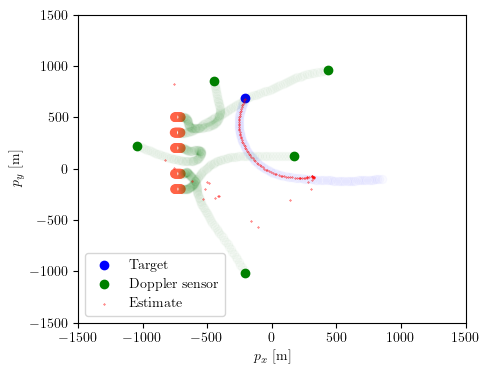

In [93]:
fig=plt.figure(figsize=(5,4))
ax = plt.gca()
xlim = [-1500,1500]
ylim = [-1500,1500]
plot_trajectories(ax,result_4['targets'], result_4['sensors'],result_4['ests'],xlim,ylim,0,T_start=10)
plt.legend()
plt.savefig('one-target-doppler-sensors.pdf')


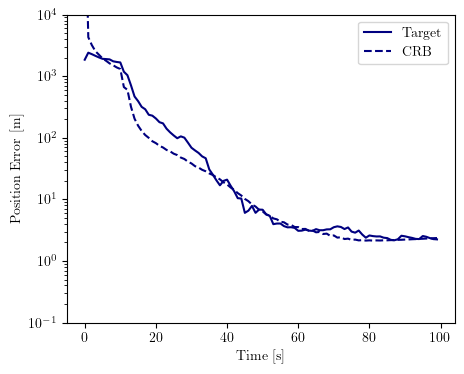

In [94]:
plt.figure(figsize=(5,4))
ax=plt.gca()
plt.plot(result_4['rmse_p'],c='Navy',label='Target')
plt.plot(result_4['crb_rmse_p'],c='Navy',linestyle='dashed',label='CRB')
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m]')
plt.yscale('log')
plt.ylim(1e-1,1e4)
plt.legend()
plt.savefig('one-target-doppler-sensors-perr.pdf')


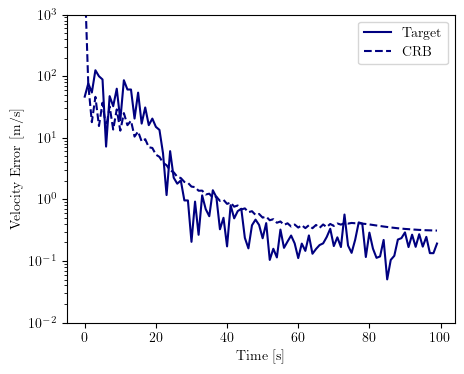

In [95]:
plt.figure(figsize=(5,4))

ax=plt.gca()
plt.plot(result_4['rmse_v'],c='Navy',label='Target')
plt.plot(result_4['crb_rmse_v'],c='Navy',linestyle='dashed',label='CRB')
plt.xlabel('Time [s]')
plt.ylabel('Velocity Error [m/s]')
plt.yscale('log')
plt.ylim(1e-2,1e3)
plt.legend()
plt.savefig('one-target-doppler-sensors-verr.pdf')



In [100]:
def case_3D_6(T):
    x_s = zeros((6,5))
    x_s[:,0] = array([250.,2000.,10,0,0.,0.])
    x_s[:,1] = array([0.,700.,-10,0,0.,0.])
    x_s[:,2] = array([-1000.,200.,10,0,0.,0.])
    x_s[:,3] = array([-1000.,-200.,10,0,0.,0.])
    x_s[:,4] = array([0.,0.,-10,0,0.,0.])
    #x_s[:,5] = array([0.,0.,-10,0,0.,0.])
  
    x_t = zeros((6,2))
    x_t[:,0] = array([2000.,-500.,0,-20.,0,0.])
    x_t[:,1] = array([2000.,500.,0.,-20.,0.,0])
    
    u_t = zeros((6,2,T))
    u_t[3,:,:T//2] = -2./T
    return x_t,x_s,u_t

In [101]:
K = 3
dim=3
bmax = 2.
amax = 2.

range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
range_u_t = [-amax,amax]
q = q_alpha_d(2*dim)
range_v = [-q,q]
Q = target3D_np.getUniformQ(amax)


x0_ = case_3D_6(T)[0]
sigma_init2 = 500**2
x0_guess = np.zeros(x0_.shape)
x0_guess[:2,:] = multivariate_normal.rvs(mean=x0_[:2,:].flatten(), cov=np.eye(2*x0_.shape[1])*sigma_init2).reshape((2,x0_.shape[1]))#a poor guess for mle initialization with variance 500^2

trajectory = case_3D_6
n_dynamic_sensors = 5
sensor_torch = MixedRangingDoppler3DFullT(1,0)
sensor_np = MixedRangingDoppler3DFull(1,0)

In [102]:
f = tracking_fuse(T,K,sensor_torch,target3D_torch,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x0_guess,3,n_dynamic_sensors,Q,T_start=0,n_iter=1000)

  0%|          | 0/100 [00:00<?, ?it/s]

In [103]:
result_two_targets_2 = extract_costs(f)


In [105]:

with open('plotsdata/3d_trajectory_6.pk','wb') as f:
    pickle.dump(result_two_targets_2,f)

In [106]:

with open('plotsdata/3d_trajectory_6.pk','rb') as f:
    result_two_targets_2 = pickle.load(f)

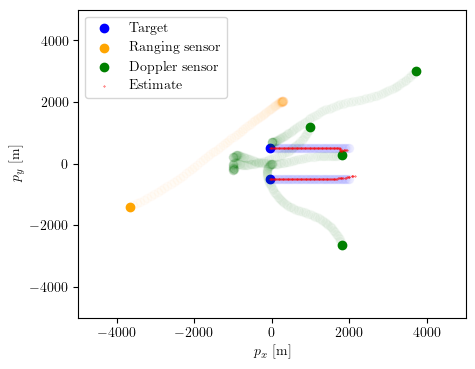

In [107]:
plt.figure(figsize=(5,4))
ax=plt.gca()
xlim = [-5000,5000]
ylim = [-5000,5000]
plot_trajectories(ax,result_two_targets_2['targets'], result_two_targets_2['sensors'],result_two_targets_2['ests'],xlim,ylim,1,T_start=0)
plt.legend()
plt.savefig('two-target-0.pdf')

In [110]:
def case_3D_7(T):
    x_s = zeros((6,5))
    x_s[:,0] = array([250.,2000.,10,0,0.,0.])
    x_s[:,1] = array([0.,700.,-10,0,0.,0.])
    x_s[:,2] = array([-1000.,200.,10,0,0.,0.])
    x_s[:,3] = array([-1000.,-200.,10,0,0.,0.])
    x_s[:,4] = array([0.,0.,-10,0,0.,0.])
  
    x_t = zeros((6,2))
    x_t[:,0] = array([2000.,-500.,0,-20.,0,0.])
    x_t[:,1] = array([2000.,500.,0.,-20.,0.,0])
    
    u_t = zeros((6,2,T))
    u_t[3,0,:T//2] = 40./T
    u_t[3,1,:T//2] = -2./T
    return x_t,x_s,u_t

In [111]:
K = 3
dim=3
bmax = 2.
amax = 2.

range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
range_u_t = [-amax,amax]
q = q_alpha_d(2*dim)
range_v = [-q,q]
Q = target3D_np.getUniformQ(amax)



x0_ = case_3D_7(T)[0]
sigma_init2 = 500**2
x0_guess = np.zeros(x0_.shape)
x0_guess[:2,:] = multivariate_normal.rvs(mean=x0_[:2,:].flatten(), cov=np.eye(2*x0_.shape[1])*sigma_init2).reshape((2,x0_.shape[1]))
print('initial_guess',x0_guess)
print('true location',x0_)

trajectory = case_3D_7
n_dynamic_sensors = 5
sensor_torch = MixedRangingDoppler3DFullT(1,0)
sensor_np = MixedRangingDoppler3DFull(1,0)

initial_guess [[ 1265.74586678  2024.93527796]
 [-1815.61798763   356.48794427]
 [    0.             0.        ]
 [    0.             0.        ]
 [    0.             0.        ]
 [    0.             0.        ]]
true location [[2000. 2000.]
 [-500.  500.]
 [   0.    0.]
 [ -20.  -20.]
 [   0.    0.]
 [   0.    0.]]


In [112]:
f = tracking_fuse(T,K,sensor_torch,target3D_torch,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x0_guess
                  ,3,n_dynamic_sensors,Q,T_start=0,n_iter=1000)
result_two_targets_3 = extract_costs(f)

  0%|          | 0/100 [00:00<?, ?it/s]

In [114]:

with open('plotsdata/3d_trajectory_7.pk','wb') as f:
    pickle.dump(result_two_targets_3,f)

In [115]:

with open('plotsdata/3d_trajectory_7.pk','rb') as f:
    result_two_targets_3 = pickle.load(f)

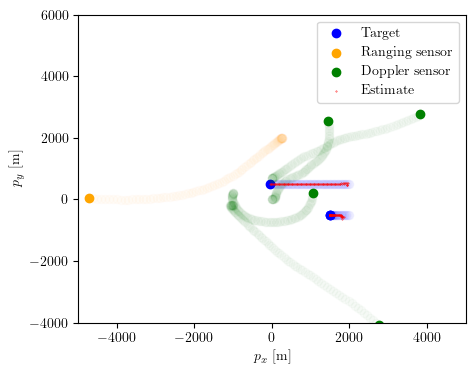

In [116]:
plt.figure(figsize=(5,4))
ax=plt.gca()
xlim = [-5000,5000]
ylim = [-4000,6000]
plot_trajectories(ax,result_two_targets_3['targets'], result_two_targets_3['sensors'],result_two_targets_3['ests'],xlim,ylim,1,T_start=0)
plt.legend()
plt.savefig('two-target-short.pdf')

In [117]:
def case_3D_8(T):
    x_s = zeros((6,5))
    x_s[:,0] = array([250.,2000.,10,0,0.,0.])
    x_s[:,1] = array([0.,700.,-10,0,0.,0.])
    x_s[:,2] = array([-1000.,200.,10,0,0.,0.])
    x_s[:,3] = array([-1000.,-200.,10,0,0.,0.])
    x_s[:,4] = array([0.,0.,-10,0,0.,0.])
  
    x_t = zeros((6,2))
    x_t[:,0] = array([0.,-500.,0,20.,0,0.])
    x_t[:,1] = array([2000.,500.,0.,-20.,0.,0])
    
    u_t = zeros((6,2,T))
    u_t[3,0,:T//2] = 2./T
    u_t[3,1,:T//2] = -2./T
    return x_t,x_s,u_t

In [118]:
K = 3
dim=3
bmax = 2.
amax = 2.

range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
range_u_t = [-amax,amax]
q = q_alpha_d(2*dim)
range_v = [-q,q]
Q = target3D_np.getUniformQ(amax)



x0_ = case_3D_8(T)[0]

sigma_init2 = 500**2
x0_guess = np.zeros(x0_.shape)
x0_guess[:2,:] = multivariate_normal.rvs(mean=x0_[:2,:].flatten(), cov=np.eye(2*x0_.shape[1])*sigma_init2).reshape((2,x0_.shape[1]))
print('initial_guess',x0_guess)
print('true location',x0_)

n_dynamic_sensors = 5
trajectory = case_3D_8
sensor_torch = MixedRangingDoppler3DFullT(1,0)
sensor_np = MixedRangingDoppler3DFull(1,0)

initial_guess [[ -71.88461035 1258.48327511]
 [-803.55143887 -164.5251883 ]
 [   0.            0.        ]
 [   0.            0.        ]
 [   0.            0.        ]
 [   0.            0.        ]]
true location [[   0. 2000.]
 [-500.  500.]
 [   0.    0.]
 [  20.  -20.]
 [   0.    0.]
 [   0.    0.]]


In [119]:
f = tracking_fuse(T,K,sensor_torch,target3D_torch,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x0_guess,3,n_dynamic_sensors,Q,n_iter=1000,T_start=0)
result_two_targets_4 = extract_costs(f)

  0%|          | 0/100 [00:00<?, ?it/s]

In [121]:

with open('plotsdata/3d_trajectory_8.pk','wb') as f:
    pickle.dump(result_two_targets_4,f)

In [122]:

with open('plotsdata/3d_trajectory_8.pk','rb') as f:
    result_two_targets_4 = pickle.load(f)

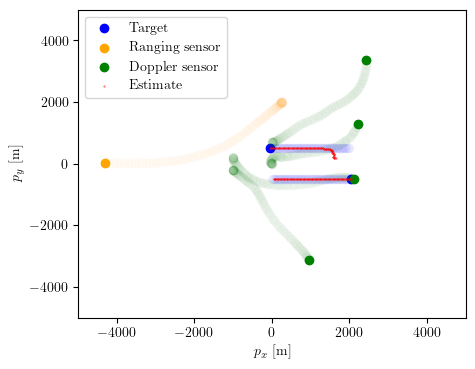

In [123]:
plt.figure(figsize=(5,4))
ax=plt.gca()
xlim = [-5000,5000]
ylim = [-5000,5000]
plot_trajectories(ax,result_two_targets_4['targets'], result_two_targets_4['sensors'],result_two_targets_4['ests'],xlim,ylim,1,T_start=0)
plt.legend()
plt.savefig('two-target-opposite.pdf')

In [124]:
def case_3D_9(T):
    x_s = zeros((6,5))
    x_s[:,0] = array([2250.,2000.,10,0,0.,0.])
    x_s[:,1] = array([2000.,700.,-10,0,0.,0.])
    x_s[:,2] = array([3000.,200.,10,0,0.,0.])
    x_s[:,3] = array([3000.,-200.,10,0,0.,0.])
    x_s[:,4] = array([2000.,0.,-10,0,0.,0.])
    #x_s[:,5] = array([0.,0.,-10,0,0.,0.])
  
    x_t = zeros((6,2))
    x_t[:,0] = array([2000.,-500.,0,-20.,0,0.])
    x_t[:,1] = array([2000.,500.,0.,-20.,0.,0])
    
    u_t = zeros((6,2,T))
    u_t[3,:,:T//2] = -2./T
    return x_t,x_s,u_t

In [125]:
K = 3
dim=3
bmax = 2.
amax = 2.

range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
range_u_t = [-amax,amax]
q = q_alpha_d(2*dim)
range_v = [-q,q]
Q = target3D_np.getUniformQ(amax)



x0_ = case_3D_9(T)[0]

sigma_init2 = 500**2
x0_guess = np.zeros(x0_.shape)
x0_guess[:2,:] = multivariate_normal.rvs(mean=x0_[:2,:].flatten(), cov=np.eye(2*x0_.shape[1])*sigma_init2).reshape((2,x0_.shape[1]))
print('initial_guess',x0_guess)
print('true location',x0_)

n_dynamic_sensors = 5
trajectory = case_3D_9
sensor_torch = MixedRangingDoppler3DFullT(1,0)
sensor_np = MixedRangingDoppler3DFull(1,0)

initial_guess [[1718.29417118 1911.93419817]
 [-368.87310638  248.96405712]
 [   0.            0.        ]
 [   0.            0.        ]
 [   0.            0.        ]
 [   0.            0.        ]]
true location [[2000. 2000.]
 [-500.  500.]
 [   0.    0.]
 [ -20.  -20.]
 [   0.    0.]
 [   0.    0.]]


In [126]:
f = tracking_fuse(T,K,sensor_torch,target3D_torch,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x0_guess,3,n_dynamic_sensors,Q,n_iter=1000,T_start=0)
result_two_targets_5 = extract_costs(f)

  0%|          | 0/100 [00:00<?, ?it/s]

In [133]:

with open('plotsdata/3d_trajectory_9.pk','wb') as f:
    pickle.dump(result_two_targets_5,f)

In [135]:

with open('plotsdata/3d_trajectory_9.pk','rb') as f:
    result_two_targets_5 = pickle.load(f)

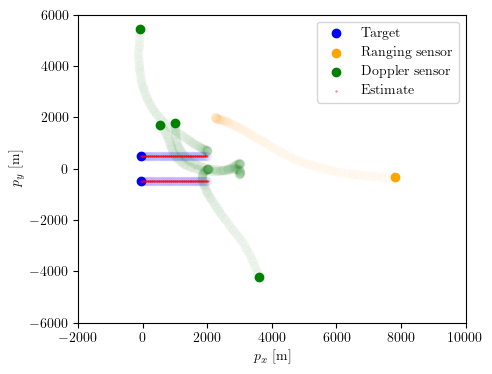

In [136]:
plt.figure(figsize=(5,4))
ax=plt.gca()
xlim = [-2000,10000]
ylim = [-6000,6000]
plot_trajectories(ax,result_two_targets_5['targets'], result_two_targets_5['sensors'],result_two_targets_5['ests'],xlim,ylim,1,T_start=0)
plt.legend()
plt.savefig('two-target-init.pdf')

In [137]:
def case_3D_13(T):
    x_s = zeros((6,4))
    x_s[:,0] = array([-752.,350.,-5,5,0.,0.])
    x_s[:,1] = array([-750,200.01,-15.,5.,0.,0.])
    x_s[:,2] = array([-750.03,-50.,-15.05,5.,0.,0.])
    x_s[:,3] = array([-749.03,-200.,5.05,5.,0.,0.])

    
    #single target
    x_t = zeros((6,1))
    x_t[:,0] = array([850,-100.,5,-1.,0.,0.])
  
    #accelerations 
    points = np.array([[850,-100],[400,-110],[0,0],[-150.,250],[-100,700]])
    _,_,a = trajectory_generator_2D(points,T+1,0)
    u_t =  zeros((6,1,T))
    
    
    u_t[3,:,:] = a[:,0]
    u_t[4,:,:] = a[:,1]
    return x_t,x_s,u_t


In [139]:
K = 3
dim=3
bmax=0.7
amax=50.
range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
range_u_t = [-amax,amax]
q = q_alpha_d(2*dim)
range_v = [-q,q]
Q = target3D_np.getUniformQ(amax)


x0_ = case_3D_12(T)[0]
sigma_init2 = 500**2
x0_guess = np.zeros(x0_.shape)
x0_guess[:2,:] = multivariate_normal.rvs(mean=x0_[:2,:].flatten(), cov=np.eye(2*x0_.shape[1])*sigma_init2,random_state=42).reshape((2,x0_.shape[1]))
print('initial_guess',x0_guess)
print('true location',x0_)

n_dynamic_sensors = 5
trajectory = case_3D_12
sensor_torch = MixedRangingDoppler3DFullT(2,0,0)
sensor_np = MixedRangingDoppler3DFull(2,0,0)

initial_guess [[1098.35707651]
 [-169.13215059]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]]
true location [[ 850.]
 [-100.]
 [   5.]
 [  -1.]
 [   0.]
 [   0.]]


In [140]:
f = tracking_fuse(T,K,sensor_torch,target3D_torch,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x0_guess,3,n_dynamic_sensors,Q,T_start=10)

  0%|          | 0/100 [00:00<?, ?it/s]

In [141]:
result_mix = extract_costs(f)


In [143]:

with open('plotsdata/3d_trajectory_12_mix.pk','wb') as f:
    pickle.dump(result_mix,f)

In [144]:

with open('plotsdata/3d_trajectory_12_mix.pk','rb') as f:
    result_mix = pickle.load(f)

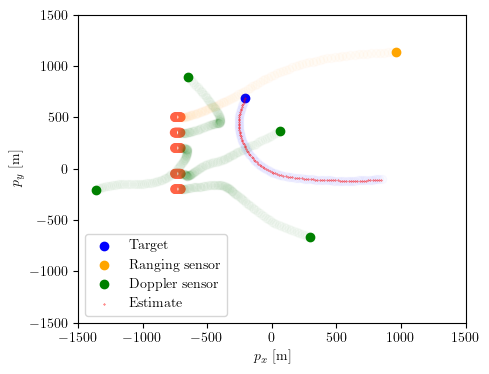

In [145]:
plt.figure(figsize=(5,4))

ax=plt.gca()
xlim = [-1500,1500]
ylim = [-1500,1500]
plot_trajectories(ax,result_mix['targets'], result_mix['sensors'],result_mix['ests'],xlim,ylim,1,T_start=10)
plt.legend()
plt.savefig('one-target-mix.pdf')


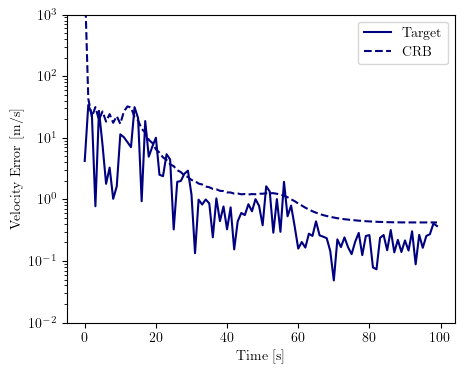

In [146]:
plt.figure(figsize=(5,4))
ax=plt.gca()
plt.plot(result_mix['rmse_v'],c='Navy',label='Target')
plt.plot(result_mix['crb_rmse_v'],c='Navy',linestyle='dashed',label='CRB')
plt.xlabel('Time [s]')
plt.ylabel('Velocity Error [m/s]')
plt.yscale('log')
plt.ylim(1e-2,1e3)
plt.legend()
plt.savefig('one-target-mix-verr.pdf')

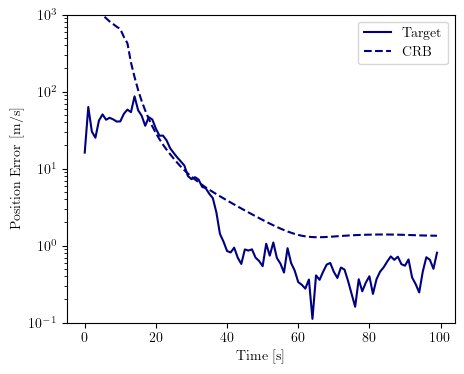

In [147]:
plt.figure(figsize=(5,4))
ax=plt.gca()
plt.plot(result_mix['rmse_p'],c='Navy',label='Target')
plt.plot(result_mix['crb_rmse_p'],c='Navy',linestyle='dashed',label='CRB')
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m/s]')
plt.ylim(1e-1,1e3)
plt.yscale('log')
plt.legend()
plt.savefig('one-target-mix-perr.pdf')


In [148]:
def case_3D_15(T):
    x_s = zeros((6,7))
    x_s[:,0] = array([0.01,-0,9.99,0,0,0])
    x_s[:,1] = array([-0.01,-2.,10.2,0.,0,0])
    x_s[:,2] = array([0.,-4,10.,10.,0.,0.])
    x_s[:,3] = array([0.01,-6,10.,0.,0.,0.])
    
    x_s[:,4] = array([-0.01,-20,10.,0.,0.,0])
    x_s[:,5] = array([-0.01,-22,10,0.,0.,0])
    x_s[:,6] = array([0.01,-24,10,0.,0.,0.])

  
    x_t = zeros((6,2))
    x_t[:,0] = array([0.,-40.,0.,3,-0.5,0.])
    x_t[:,1] = array([0.,-40.,0.,3,0.5,0.])
    
    u_t =  zeros((6,2,T))
    u_t[3,:,:] = -5/T
    u_t[4,0,:] = -15/T
    u_t[4,1,:] = 15/T
    return x_t,x_s,u_t


In [149]:
bmax = 0.2
amax = 0.3
dim = 3
q = q_alpha_d(2*dim)

range_u_s = [-bmax/np.sqrt(dim),bmax/np.sqrt(dim)]
range_u_t = [-amax,amax]
range_v = [-q,q]
Q = target3D_np.getUniformQ(amax)

trajectory = case_3D_15
n_dynamic_sensors = 7
sensor_torch = MixedRangingDoppler3DFullT(4,0,0)
sensor_np = MixedRangingDoppler3DFull(4,0,0)

x0_ = case_3D_15(T)[0]
sigma_init2 = 50**2
x0_guess = np.zeros(x0_.shape)
for it in range(x0_.shape[1]):
    x0_guess[:dim,it] = multivariate_normal.rvs(mean=x0_[:dim,it].flatten(), cov=np.eye(dim)*sigma_init2)
print('initial_guess',x0_guess)
print('true location',x0_)


initial_guess [[-12.02806119 -23.45488931]
 [  4.03634065 -19.46260656]
 [ 40.29123421  35.48674631]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]]
true location [[  0.    0. ]
 [-40.  -40. ]
 [  0.    0. ]
 [  3.    3. ]
 [ -0.5   0.5]
 [  0.    0. ]]


In [159]:
f = tracking_fuse(T,K,sensor_torch,target3D_torch,sensor_np,target3D_np,lr_s,lr_t,range_u_s,range_u_t,range_v,w,trajectory,x0_guess,3,n_dynamic_sensors,Q,T_start=0)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
result_last = extract_costs(f)


In [168]:

with open('plotsdata/3d_trajectory_15_mix.pk','wb') as f:
    pickle.dump(result_last,f)

In [169]:

with open('plotsdata/3d_trajectory_15_mix.pk','rb') as f:
    result_last = pickle.load(f)

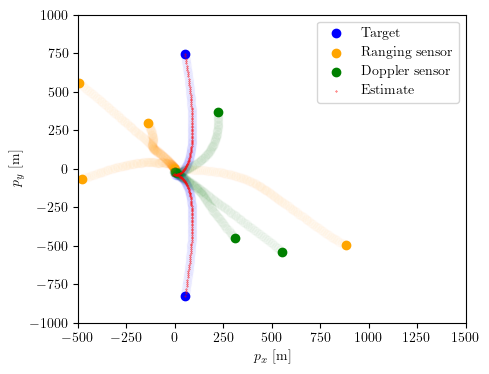

In [170]:
plt.figure(figsize=(5,4))

ax=plt.gca()
xlim = [-500,1500]
ylim = [-1000,1000]
plot_trajectories(ax,result_last['targets'], result_last['sensors'],result_last['ests'],xlim,ylim,4,T_start=0)
plt.legend()
plt.savefig('two-targets-mix3.pdf')


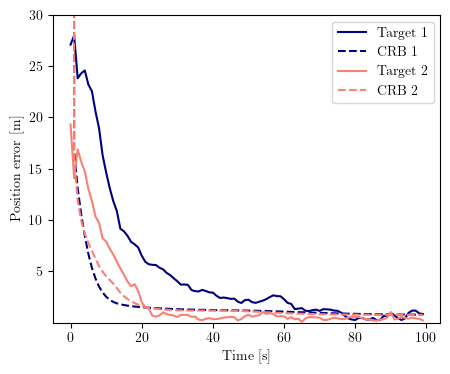

In [171]:
plt.figure(figsize=(5,4))

ax=plt.gca()
plt.plot(result_last['rmse_p'][:,0],c='navy',label='Target 1')
plt.plot(result_last['crb_rmse_p'][:,0],c='navy',linestyle='dashed',label='CRB 1')
plt.plot(result_last['rmse_p'][:,1],c='salmon',label='Target 2')
plt.plot(result_last['crb_rmse_p'][:,1],c='salmon',linestyle='dashed',label='CRB 2')
plt.xlabel('Time [s]')
plt.ylabel('Position error [m]')
plt.ylim(1e-2,30)
#plt.yscale('log')
plt.legend(loc='best')

plt.savefig('two-targets-mix-err3.pdf')
